# Filter questions answered (hopefully)

See [questions.ipynb](./questions.ipynb) for the theory and questions.

## Experiment 1: Summing amp speed and r_series_tau

- Disable filter2, set acquisition speed to the highest
- Disable prediction, set compensation as low as it can go without being off, e.g. 1%
- Perform a few simple voltage steps
- Repeat with different `r_series_tau` settings.
- TEST: Does `r_series_tau` affect I_obs ?

In [1]:
import myokit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

/home/michael/dev/myokit/myokit/__init__.py:65: UserWarning: Using development version of Myokit (1.37.4.dev).
  warnings.warn(f'Using development version of Myokit ({__version__}).')


In [2]:
# Model with finite summing speed, and Fs and F1
m1 = myokit.load_model('m-new-0.mmt')
m1.check_units(myokit.UNIT_STRICT)

In [3]:
# Model with instantaneous summing, Fs, F1, and a 1-pole Rs comp lag
m2 = myokit.load_model('m-new-1.mmt')
m2.check_units(myokit.UNIT_STRICT)

In [4]:
p = myokit.Protocol()
p.add_step(level=-100, duration=100)
p.add_step(level=+100, duration=100)

s1 = myokit.Simulation(m1, p)
s1.set_tolerance(1e-8, 1e-8)
s1.pre(99)

s2 = myokit.Simulation(m2, p)
s2.set_tolerance(1e-8, 1e-8)
s2.pre(99)

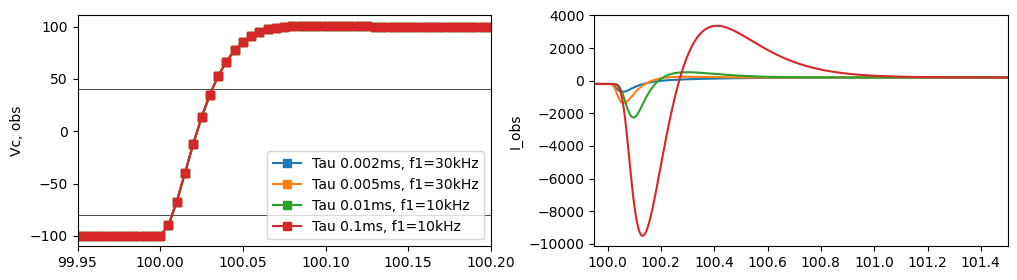

In [5]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

ts = [2e-3, 5e-3, 10e-3, 100e-3]  # us
fs = [30, 30, 10, 10]  # kHz

s = s1
tau_name = 'amp.tau_sum'
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.01)
    s.set_constant('amp.beta', 0)
    s.set_constant(tau_name, tau)
    s.set_constant('amp.f1', fc)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}ms, f1={fc}kHz')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

As shown above, $\tau$ has a considerable influence on the voltage step (in the first half a millisecond!) even though Rs compensation is at 1% and prediction is disabled.

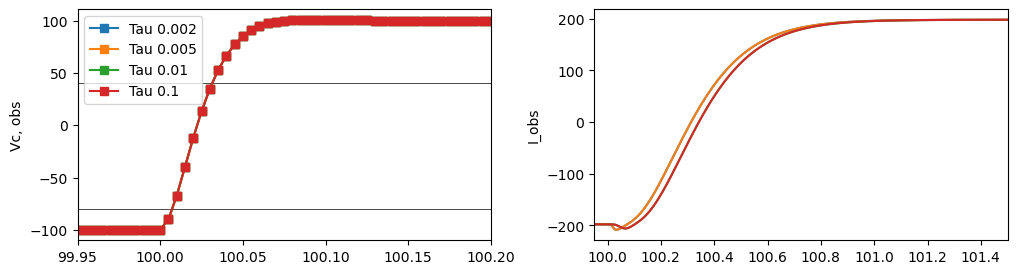

In [6]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = s2
tau_name = 'amp.tau_rc'
for tau, fc in zip(ts, fs):
    s.reset()
    s.set_constant('amp.alpha', 0.01)
    s.set_constant('amp.beta', 0)
    s.set_constant(tau_name, tau)
    s.set_constant('amp.f1', fc)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'Tau {tau}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

In the model where Rs has a lag but the summing amp does not, we see no effect except for a minor change when switching between filters.
So this experiment can be used to decide if the summing amp or just Rs compensation is slowed by `r_series_tau`.

Now let's look at the data:

In [7]:
def load(exp, *selection):
    logs = []
    for s in selection:
        logs.append(myokit.DataLog.load(
            f'data/E-{exp}-{s:0>3}-FilterTest.zip').npview())
    return logs

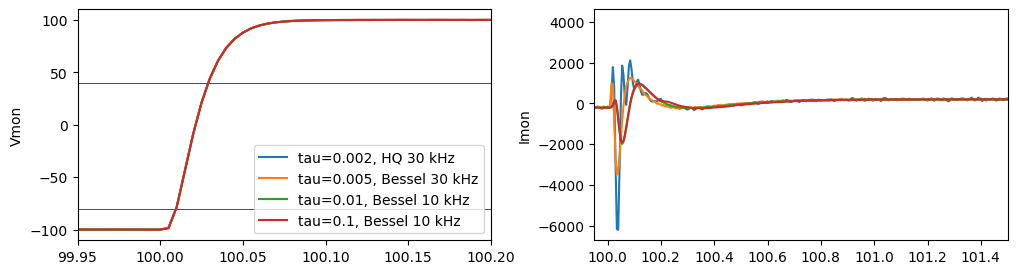

In [8]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vmon')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('Imon')

logs = load(408, 3, 2, 1, 0)
for d in logs:
    tau = float(d.meta['r_series_compensation_tau_us']) * 1e-3
    f1 = d.meta['filter1']
    ax1.plot(d.time(), d['0.Vmon'], label=f'tau={tau}, {f1}')
    ax2.plot(d.time(), d['0.Imon'])

ax1.legend()
plt.show()

Observations:

- Unlike in Simulation 2, we see a sizeable artefact
- But unlike Simulation 1, this artefact is much faster, and only slightly dependent on the `r_series_tau` setting
- The two traces with identical filter1 settings appear to overlap, suggesting that the difference between the traces is due to the different filter1 settings.

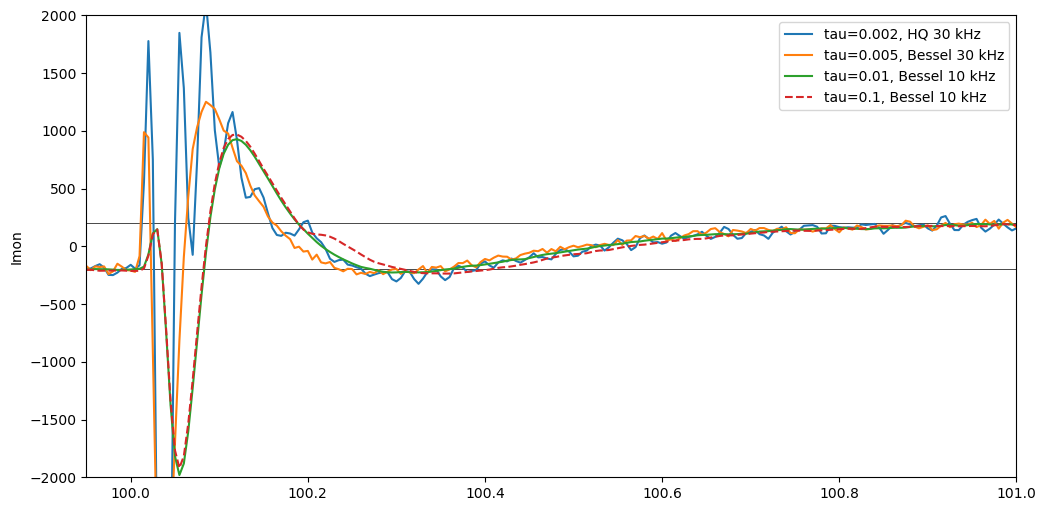

In [9]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot()
ax1.set_xlim(99.95, 101)
ax1.axhline(-200, lw=0.5, color='k')
ax1.axhline(200, lw=0.5, color='k')
ax1.set_ylabel('Imon')
ax1.set_ylim(-2000, 2000)

lines = ('-', '-', '-', '--')
for d, ls in zip(logs, lines):
    tau = float(d.meta['r_series_compensation_tau_us']) * 1e-3
    f1 = d.meta['filter1']
    ax1.plot(d.time(), d['0.Imon'], ls=ls, label=f'tau={tau}, {f1}')
ax1.legend()
plt.show()

Zooming in we can see that the 3d and 4th traces are almost identical.
Something strange happens in the red trace around 100.2.
Could something somewhere in the system be picking up a bit of charge somehow?
E.g. a tiny capacitor gets charged somehow?

We can also have a look at other steps

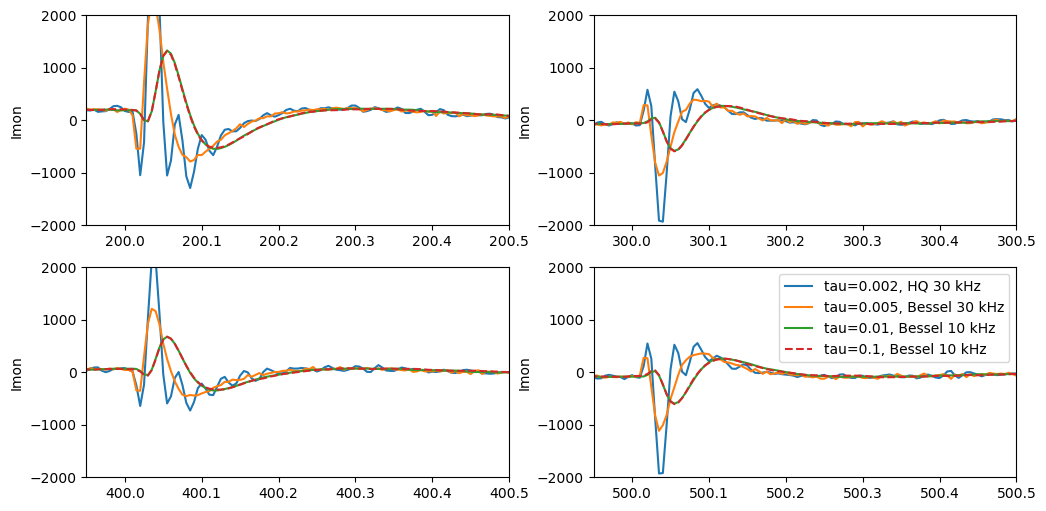

In [10]:
fig = plt.figure(figsize=(12, 6))
for i, x in enumerate((200, 300, 400, 500)):
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.set_xlim(x - 0.05, x + 0.5)
    ax.set_ylabel('Imon')
    ax.set_ylim(-2000, 2000)
    for d, ls in zip(logs, lines):
        tau = float(d.meta['r_series_compensation_tau_us']) * 1e-3
        f1 = d.meta['filter1']
        ax.plot(d.time(), d['0.Imon'], ls=ls, label=f'tau={tau}, {f1}')
ax.legend()
plt.show()

In these, it looks even more plausible that we are looking at the same artefact, filtered in 3 different ways.

We can get an idea of what the filter does by applying filters to the 30kHz "HQ" filtered signal.
This isn't _exactly_ the same, because it means we're looking at two filters in a row (so end result is a lower frequency, with more delay).

In [11]:
import scipy.signal

def low_pass(time, data, f, n=6):
    """ Emulate an analog Bessel low-pass filter with cut-off f (in kHz for time in ms). """
    b, a = scipy.signal.bessel(n, 2 * np.pi * f, analog=True, norm='mag')
    t, y, _ = scipy.signal.lsim((b, a), data, time)
    return t, y

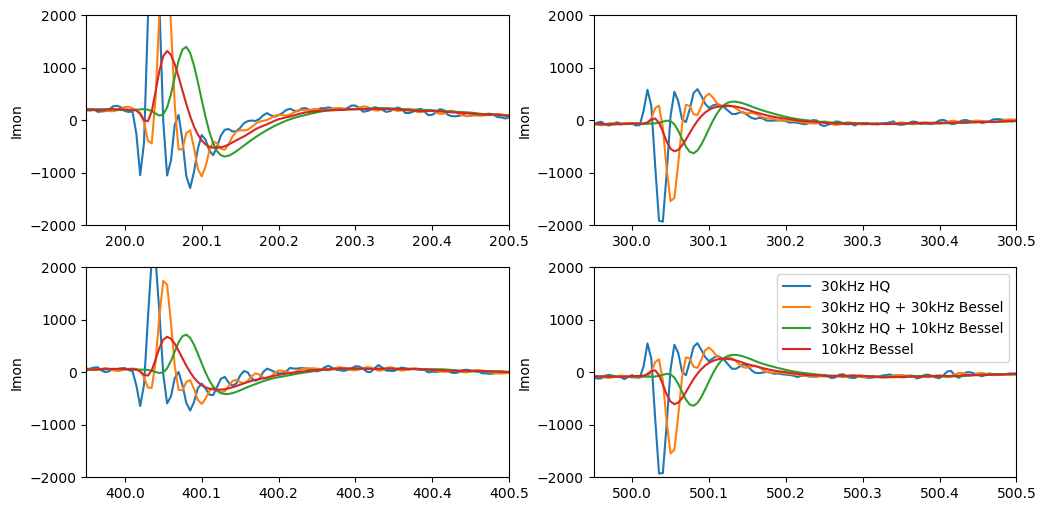

In [12]:
d = logs[0]
t0, i0 = 0.005 * np.arange(len(d.time())), d['0.Imon']
t1, i1 = low_pass(t0, i0, 30)
t2, i2 = low_pass(t0, i0, 10)
t3, i3 = t0, logs[3]['0.Imon']

fig = plt.figure(figsize=(12, 6))
for i, x in enumerate((200, 300, 400, 500)):
    ax = fig.add_subplot(2, 2, 1 + i)
    ax.set_xlim(x - 0.05, x + 0.5)
    ax.set_ylabel('Imon')
    ax.set_ylim(-2000, 2000)
    ax.plot(t0, i0, label='30kHz HQ')    
    ax.plot(t1, i1, label='30kHz HQ + 30kHz Bessel')
    ax.plot(t2, i2, label='30kHz HQ + 10kHz Bessel')
    ax.plot(t3, i3, label='10kHz Bessel')    
ax.legend()
plt.show()

From this it looks very plausible that the observed difference is purely due to the filtering.

Conclusions:

1. `r_series_tau` should not determine the "summing speed".
2. There is a larger artefact than in the simulations, so there may still be a case for a summing speed, but more simply it indicates the result of a slightly imperfect Cp compensation.

In [13]:
del s1, s2

## Experiment 2a: Stimulus filter

- Disable filter2, set acquisition speed to the highest
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with both settings (20us, 2us)
- TEST: Does our 40us, 4us approximation hold?

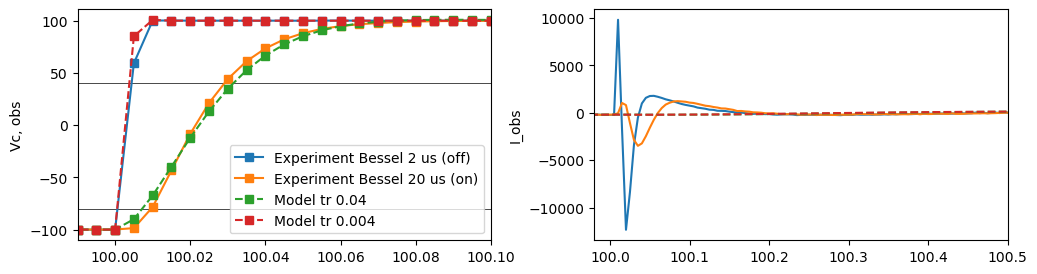

In [14]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.99, 100.1)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, obs')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.98, 100.5)
ax2.set_ylabel('I_obs')

logs = load(409, 3, 2)
for d in logs:
    ax1.plot(d.time(), d['0.Vmon'], 's-', label=f'Experiment {d.meta['stimulus_filter']}')
    ax2.plot(d.time(), d['0.Imon'])

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for tr in [40e-3, 4e-3]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.tr', tr)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's--', label=f'Model tr {tr}')
    ax2.plot(d.time(), d['amp.I_obs'], '--')
ax1.legend()
plt.show()

This shows that the model is pretty close - provided we use double the official rise time.

## Experiment 2d: Vary Cfast estimates

We now change the order of things and jump to experiment 2d.
The goal is to see if the predictions of wrong Cslow and Cfast estimates line up with the data qualitatively.
If so, we can try fitting the model to the data.

- Set acquisition speed to the highest, disable filter2, set filter1 to 30kHz
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with different Cfast settings
- TEST: Does our model qualitatively reproduce these effects?

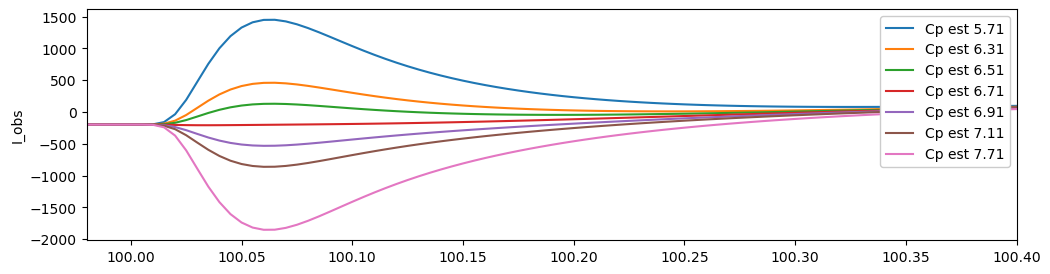

In [15]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.4)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.f1', 30)
for cp in [5.71, 6.31, 6.51, 6.71, 6.91, 7.11, 7.71]:
    s.reset()
    s.set_constant('amp.Cp_est', cp)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], '-', label=f'Cp est {cp}')
s.set_constant('amp.Cp_est', 6.71)
ax2.legend(loc='upper right', framealpha=1)
plt.show()

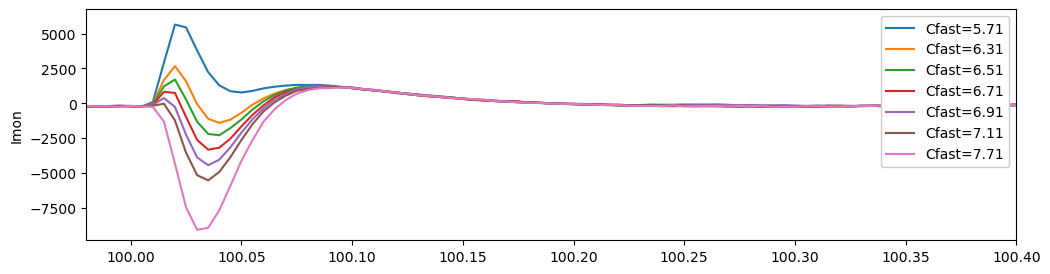

In [16]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.4)
ax2.set_ylabel('Imon')
for d in load(412, 6, 2, 1, 5, 3, 4, 8):
    cf = float(d.meta['c_fast_pF'])
    ax2.plot(d.time(), d['0.Imon'], label=f'Cfast={cf:.3}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

Observations:
- The trends are in the right direction (too low causes positive deflection, too high causes negative)
- The experimental artefacts are much faster, and much larger than the simulated ones
- The experimental behaviour is more complex. Possibly this is due to the two-levels of Cfast compensation.

### Cell-attached Cfast variation

In simulation, this looks very similar to the (perfectly Cslow compensated) cell-attached case:

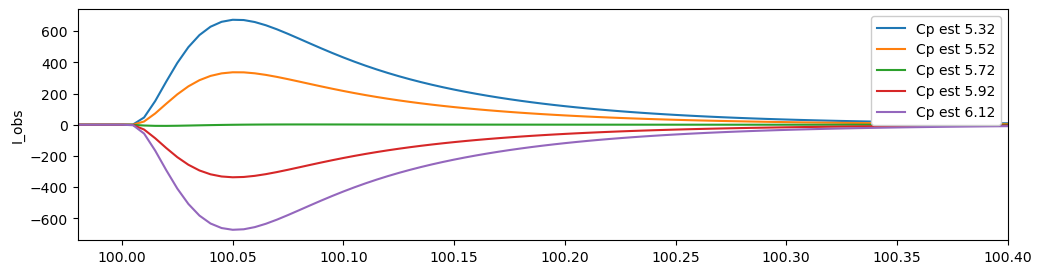

In [17]:
s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.f1', 100)

# Cell-attached configuration
s.set_constant('amp.Cp', 5.72)
s.set_constant('amp.Cm', 1e-6)
s.set_constant('amp.Cm_est', 1e-6)
s.set_constant('amp.g', 0)

fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.4)
ax2.set_ylabel('I_obs')
for cp in [5.32, 5.52, 5.72, 5.92, 6.12]:
    s.reset()
    s.set_constant('amp.Cp_est', cp)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], '-', label=f'Cp est {cp}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

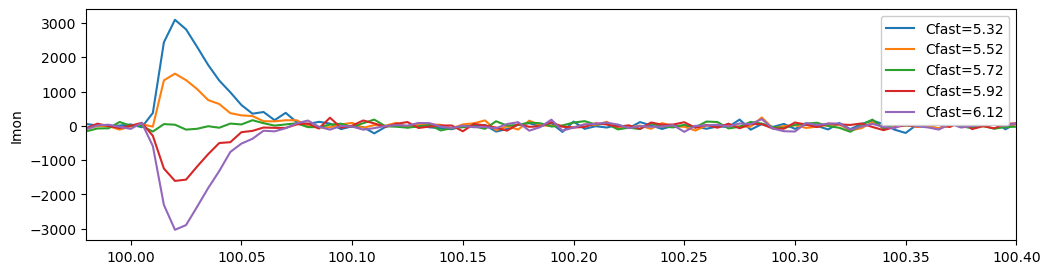

In [18]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.4)
ax2.set_ylabel('Imon')
for d in load(417, 2, 1, 0, 3, 4):
    cf = float(d.meta['c_fast_pF'])
    f1 = d.meta['filter1']
    ax2.plot(d.time(), d['0.Imon'], label=f'Cfast={cf:.3}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

Qualitatively these are highly similar.
However, the experimental artefacts are larger and faster than the simulated ones.

### Modelling two-part Cfast cancellation

To add this, we need to replace the term $C_p^* dV_\text{ref}$ in

\begin{align}
2. && (C_p+C_f)\dot{V}_p = \frac{V_o - V_p}{R_f} - \frac{V_p + E_\text{off}^\dagger - V_m}{R_s} + C_f\dot{V}_o + C_m^* \dot{V}_\text{est} + C_p^* dV_\text{ref}
\end{align}

with a two part equation:

\begin{align}
C_{p1}^* dV_\text{ref,1} + C_{p2}^* \dot{V}_\text{ref,2} &&
\dot{V}_\text{ref,2} = \frac{V_\text{ref,1} - V_\text{ref,2}}{\tau_2}
\end{align}

In [20]:
# Model with instantaneous summing, Fs, F1, and a 1-pole Rs comp lag
m3 = myokit.load_model('m-new-3.mmt')
m3.check_units(myokit.UNIT_STRICT)

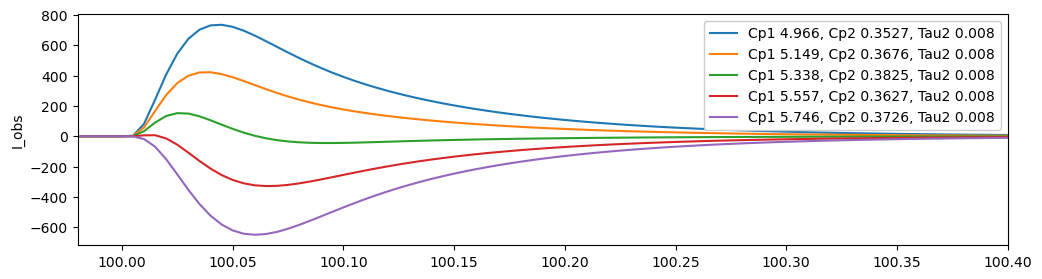

In [21]:
s = myokit.Simulation(m3, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.f1', 100)

# Cell-attached configuration
s.set_constant('amp.Cp', 5.72)
s.set_constant('amp.Cm', 1e-6)
s.set_constant('amp.Cm_est', 1e-6)
s.set_constant('amp.g', 0)

cp1s, cp2s, ta2s = [], [], []
for d in load(417, 2, 1, 0, 3, 4):
    cp1s.append(float(d.meta['c_fast_amp1_pF']))
    cp2s.append(float(d.meta['c_fast_amp2_pF']))
    ta2s.append(float(d.meta['c_fast_tau2_us']) * 1e-3)

fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.4)
ax2.set_ylabel('I_obs')
for cp1, cp2, tau2 in zip(cp1s, cp2s, ta2s):
    s.reset()
    s.set_constant('amp.Cp_est1', cp1)
    s.set_constant('amp.Cp_est2', cp2)
    s.set_constant('amp.Cp_tau2', tau2)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], '-', label=f'Cp1 {cp1:.4}, Cp2 {cp2:.4}, Tau2 {tau2:.4}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

## Experiment 2e: Vary Cslow estimates

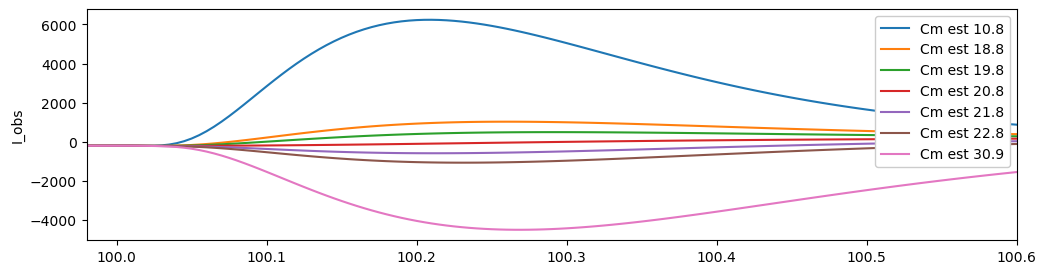

In [22]:
s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0)
s.set_constant('amp.beta', 0)
s.set_constant('amp.f1', 30)

fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.6)
ax2.set_ylabel('I_obs')
for cm in [10.8, 18.8, 19.8, 20.8, 21.8, 22.8, 30.9]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.Cm_est', cm)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], label=f'Cm est {cm}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

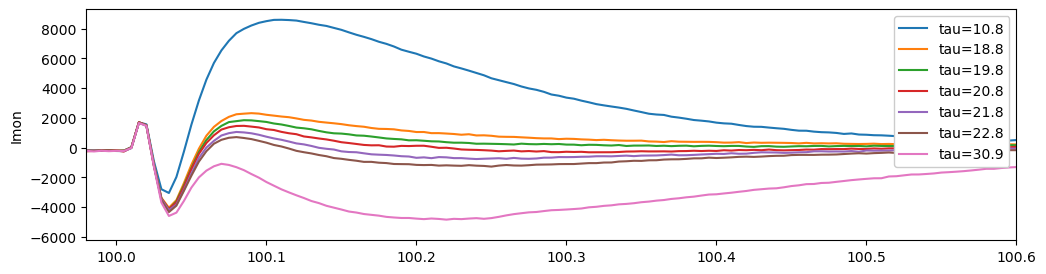

In [23]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax2 = fig.add_subplot()
ax2.set_xlim(99.98, 100.6)
ax2.set_ylabel('Imon')
for d in load(413, 6, 2, 1, 0, 3, 4, 7):
    cf = float(d.meta['c_slow_pF'])
    f1 = d.meta['filter1']
    ax2.plot(d.time(), d['0.Imon'], label=f'tau={cf:.3}')
ax2.legend(loc='upper right', framealpha=1)
plt.show()

This looks qualitatively alright!
The size of the errors is also approximately correct.

## Experiment 2b: Vary filter1

- Disable filter2, set acquisition speed to the highest [leave stimulus filter at default, see below]
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with four different filter1 settings (Bessel 100, 30, 10, HQ30)
- TEST: Does our model fit these traces well?

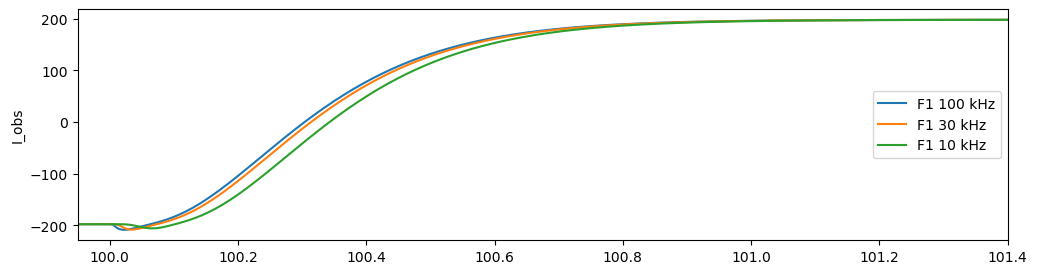

In [29]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 101.4)
ax2.set_ylabel('I_obs')
s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for fc in [100, 30, 10]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', fc)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], label=f'F1 {fc} kHz')
ax2.legend(loc='right')
plt.show()

Note: The effects are small (overshadowed by charging time, I guess). But it will be a good test to see if we get _any_ of these right.
Also the general pattern.

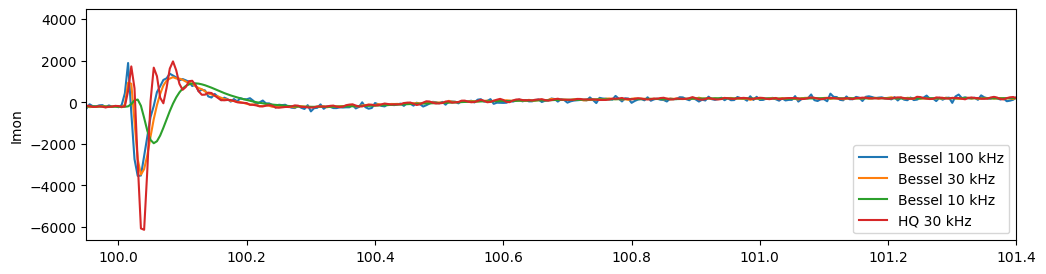

In [30]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 101.4)
ax2.set_ylabel('Imon')
logs = load(410, 0, 1, 2, 3)
for d in logs:
    ax2.plot(d.time(), d['0.Imon'], label=d.meta['filter1'])
ax2.legend()
plt.show()

As the real signal is much more interesting, the effects of the filter are much more clearly visible.
Just like in the simulation, the difference between the 100kHz and 30kHz filters is minimal.

## Experiment 2c: Vary filter2

- Set acquisition speed to the highest, set filter1 to 30kHz
- Disable prediction and compensation
- Perform a few simple voltage steps
- Repeat with four different filter2 settings
- TEST: Does our model fit these traces well?

In [31]:
# Model with instantaneous summing, Fs, F1, F2, and a 1-pole Rs comp lag
m4 = myokit.load_model('m-new-2.mmt')
m4.check_units(myokit.UNIT_STRICT)

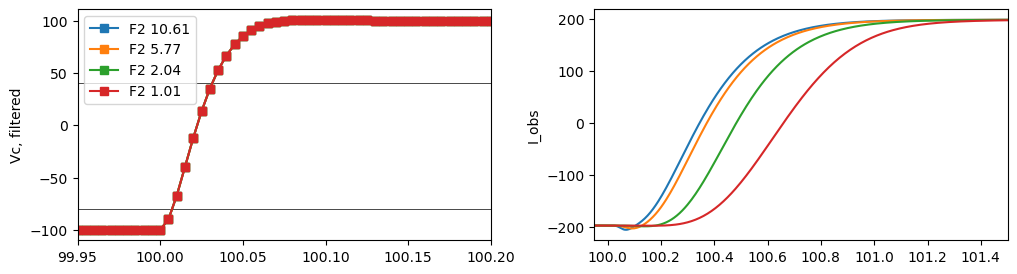

In [32]:
fig = plt.figure(figsize=(12, 3))
fig.subplots_adjust(wspace=0.25)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(99.95, 100.2)
ax1.axhline(-80, lw=0.5, color='k')
ax1.axhline(40, lw=0.5, color='k')
ax1.set_ylabel('Vc, filtered')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m4, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
for fc in [10.61, 5.77, 2.04, 1.01]:
    s.reset()
    s.set_constant('amp.alpha', 0)
    s.set_constant('amp.beta', 0)
    s.set_constant('amp.f1', 30)
    s.set_constant('amp.f2', fc)    
    s.set_constant(tau_name, tau)
    d = s.run(200, log_interval=0.005)
    ax1.plot(d.time(), d['amp.Vs2'], 's-', label=f'F2 {fc}')
    ax2.plot(d.time(), d['amp.I_obs'])
ax1.legend()
plt.show()

It'd be very pleasing if we could match these (which include Fs, F1, and F2 effects).

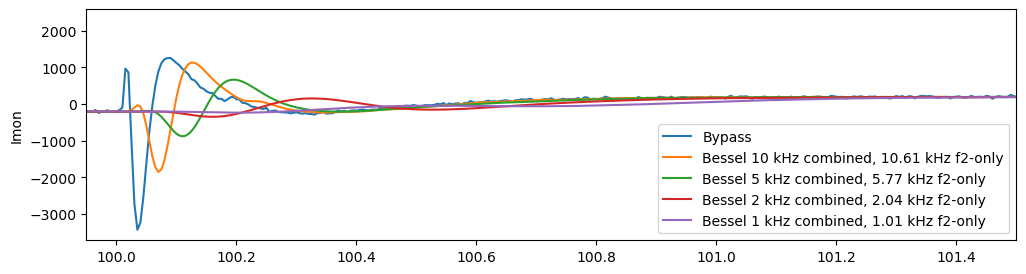

In [33]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('Imon')
logs = load(411, 0, 1, 2, 3, 4)
for d in logs:
    ax2.plot(d.time(), d['0.Imon'], label=d.meta['filter2'])
ax2.legend()
plt.show()

Unfortunately will need to match the bypassed filter much closer to see if the filter 2 implementation is any good.

## Experiment 3a: Vary `r_series_tau`

- Set acquisition speed to the highest, disable filter2, let filter1 be set by software
- Set compensation and prediction to 70% and 0%
- Perform a few simple voltage steps
- Repeat with different `r_series_tau` settings
- Then repeat with prediction at 70%
- TEST: Does our model fit these traces well?

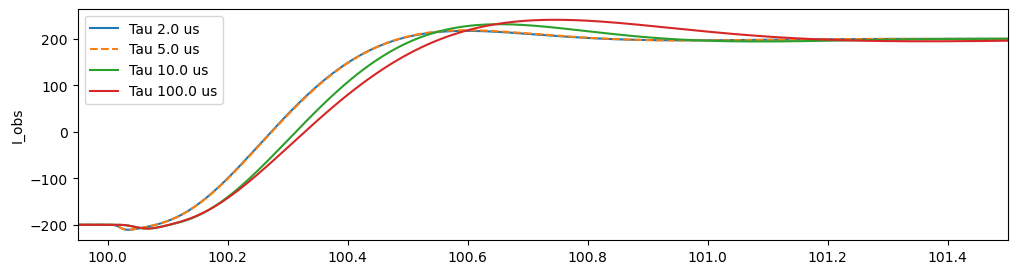

In [34]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

ts = [2e-3, 5e-3, 10e-3, 100e-3]  # ms
fs = [30, 30, 10, 10]  # kHz

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0.7)
s.set_constant('amp.beta', 0)
for tau, fc in zip(ts, fs):
    s.reset()    
    s.set_constant('amp.f1', fc)
    s.set_constant('amp.tau_rc', tau)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], 
             ls='--' if tau == 0.005 else '-', 
             label=f'Tau {1e3 * tau} us')
ax2.legend()
plt.show()

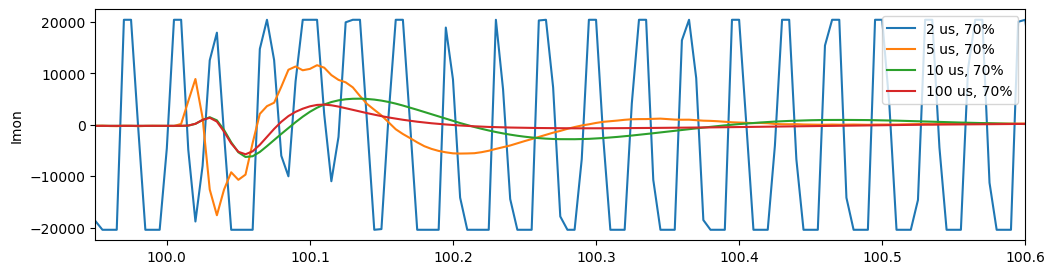

In [35]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 100.6)
ax2.set_ylabel('Imon')
logs = load(414, 4, 3, 1, 0)
for d in logs:
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax2.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
ax2.legend()
plt.show()

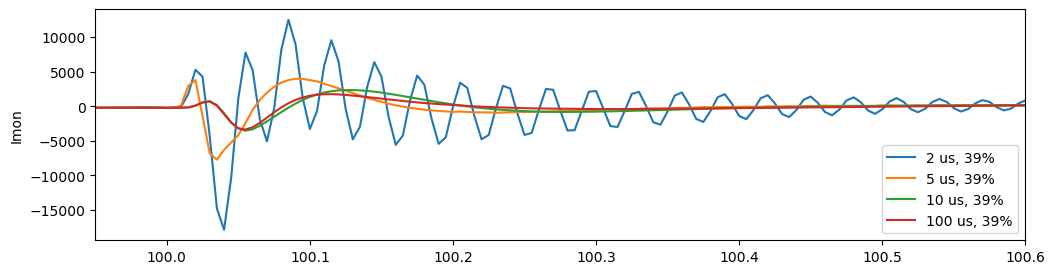

In [36]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 100.6)
ax2.set_ylabel('Imon')
logs = load(414, 5, 6, 7, 8)
for d in logs:
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax2.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
ax2.legend()
plt.show()

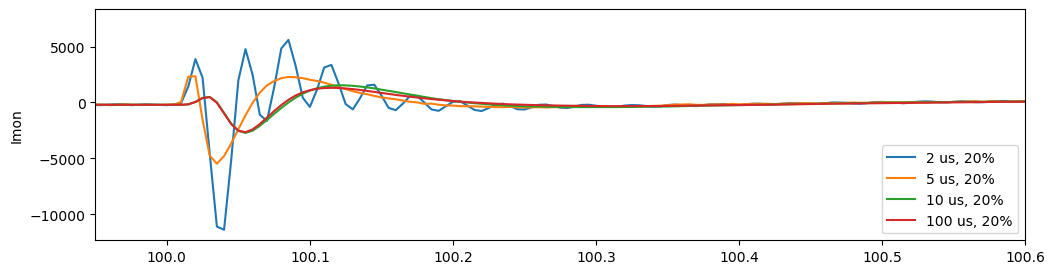

In [37]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 100.6)
ax2.set_ylabel('Imon')
logs = load(414, 9, 10, 11, 12)
for d in logs:
    tau = int(float(d.meta['r_series_compensation_tau_us']))
    alp = int(float(d.meta['r_series_compensation_percent']))    
    ax2.plot(d.time(), d['0.Imon'], label=f'{tau} us, {alp}%')
ax2.legend()
plt.show()

Need better fit.

## Experiment 3b: `r_series_tau` with prediction

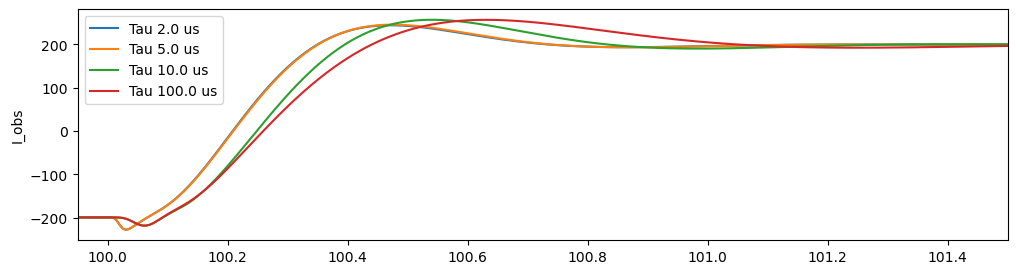

In [38]:
fig = plt.figure(figsize=(12, 3))
ax2 = fig.add_subplot()
ax2.set_xlim(99.95, 101.5)
ax2.set_ylabel('I_obs')

s = myokit.Simulation(m2, p)
s.set_tolerance(1e-8, 1e-8)
s.pre(99)
s.set_constant('amp.alpha', 0.7)
s.set_constant('amp.beta', 0.7)
for tau, fc in zip(ts, fs):
    s.reset()    
    s.set_constant('amp.f1', fc)
    s.set_constant('amp.tau_rc', tau)
    d = s.run(200, log_interval=0.005)
    ax2.plot(d.time(), d['amp.I_obs'], label=f'Tau {tau * 1e3} us')
ax2.legend()
plt.show()

# Don't know how to read out prediction fraction!